## Resource competition in variable environments

#### Andrew D. Letten (andrew.letten@usys.ethz.ch)


### 1. Resource competition at equilibrium (review)

#### 1.1 Two consumers and a single abiotic resource

In an equilibrium environment, where a single resource is delivered to a system at constant rate, all else being equal, coexistence of competitors is not possible. The winning consumer is the one that can draw the resource down to the lowest level (i.e. has the lowest R$^*$). This is a resource-explicit statement of the principle of **Competitive Exclusion**


If the per-capita growth rate is defined as a Monod function, i.e.

\begin{equation}
\frac{dN_{i}}{dt} = N_{i}(\frac{\mu _{max_{i}}R}{k_{i} + R} - d)
\end{equation}


then, 

\begin{equation}
R^* = \frac{dk_{i}}{\mu_{max_{i}}  - d}
\end{equation}

In [10]:
# Required packages
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(deSolve)
options(repr.plot.width=4, repr.plot.height=4)
cbbPalette = c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Define function for Monod functional response

In [11]:
monod.sim = function(x = R, r = r, k = k){
  per.cap = r*x/(k+x)
  return(per.cap)
}

Choose growth parameters for consumer 1 & 2

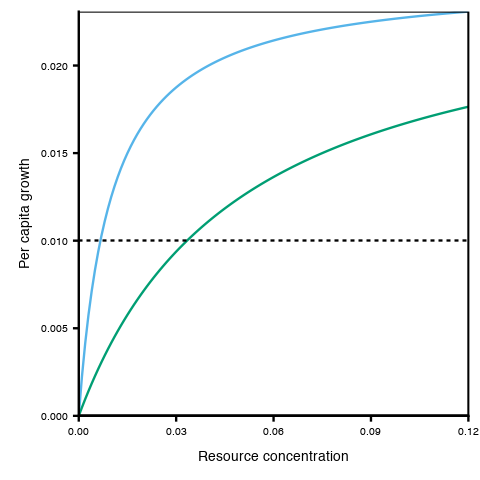

In [18]:
r1 = 0.025; r2 = 0.025 # maximum growth rate
k1 = 0.01; k2 = 0.05 # half stauration constant
Q = 0.0001 # resource quota
d = 0.01 # density independent mortality
resource = 0.12 # resource supply concentration

resource.levels = seq(0,resource,by = 0.001) 
resp.blue = monod.sim(x = resource.levels, r = r1, k = k1)
resp.red = monod.sim(x = resource.levels, r = r2, k = k2)

monod.mat = data.frame(resource.levels,resp.blue,resp.red)
monod.gg = gather(monod.mat, key = resp, value = count, -resource.levels)
names(monod.gg)[2] = c("sp")

ggplot(monod.gg, aes(y = count, x = resource.levels)) +
  geom_line(aes(col = sp)) + 
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  xlab("Resource concentration") + ylab("Per capita growth") +
  panel_border(colour = "black") + geom_hline(yintercept = d, linetype = "dashed") + 
  theme(axis.text = element_text(size = 6),
        axis.title= element_text(size = 8)) +
  coord_cartesian(expand = FALSE)

In [19]:
mymonod.chemo = function(Time, State, Pars)
{
  with(as.list(c(State, Pars)),
       {
         dN1 = N1*r1*R/(k1+R) - d*N1
         dN2 = N2*r2*R/(k2+R) - d*N2
         dR =  d*(resource-R) - ((N1*R*r1*Q)/(k1+R)) - ((N2*R*r2*Q)/(k2+R))
         return(list(c(dN1, dN2, dR)))
       })
}

monod.ini=c(N1=10, N2=10, R=resource)
model = mymonod.chemo
time.total = 1000 # real length of simulation
times=round(seq(0.1,time.total,by=0.1),1) # total number of time-steps

# Run the numerical simulations
out.monod=as.data.frame(ode(func=model,
                            y=monod.ini,
                            parms=NULL,
                            times=times,
                            method = "lsoda"))

#baseplot.ode(out.monod)

comp.gg = gather(out.monod, state.var, count, -time)


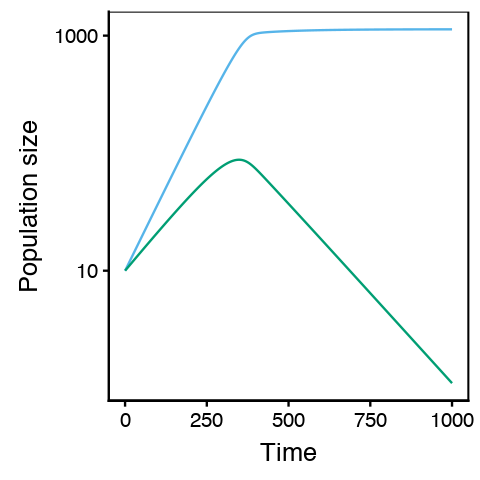

In [21]:
ggplot(comp.gg[comp.gg$state.var != "R",], aes(y = count, x= time)) +
  geom_line(aes(group = state.var, col = state.var)) + scale_y_log10() +
  scale_color_manual(values = cbbPalette[2:3]) +
  theme(legend.position="none") + 
  ylab(expression(paste("Population size"))) + xlab("Time") +
  panel_border(colour = "black") +
  theme(axis.text = element_text(size = 12),
        axis.title= element_text(size = 15)) 